In [1]:
import pandas as pd
import numpy as np
import math
import random

RANDOM_STATE = 123
np.random.seed(123)

## Load data

In [2]:
df_gym = pd.read_csv('data/modified_gym_members_exercise_tracking.csv')

In [3]:
df_heart_rates = pd.read_csv('data/gym_members_heart_rates.csv')

In [4]:
df_heart_rates.head()

,User_ID,Heart_Rate
0,0,138
1,0,153
2,0,146
3,0,162
4,0,161


In [5]:
df_heart_rates['User_ID'].unique().shape

(713,)

In [6]:
df_gym.shape

(713, 15)

## Energy calculation - Fuzzy Logic

### Fuzzy controller

In [7]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [8]:
class FuzzyController:
    def __init__(self):
        self.bpm_antecedent = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'Normalized BPM')
        self.bpm_variation_antecedent = ctrl.Antecedent(np.arange(-0.2, 0.21, 0.01), 'Normalized BPM Variation')
        self.intensity_consequent = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'Intensity')

        # Funciones de membresía normalizadas (idénticas para todos los usuarios)
        self.bpm_antecedent['Very Low'] = fuzz.trimf(self.bpm_antecedent.universe, [0.0, 0.0, 0.3])
        self.bpm_antecedent['Low'] = fuzz.trimf(self.bpm_antecedent.universe, [0.2, 0.4, 0.6])
        self.bpm_antecedent['Medium'] = fuzz.trimf(self.bpm_antecedent.universe, [0.5, 0.65, 0.8])
        self.bpm_antecedent['High'] = fuzz.trimf(self.bpm_antecedent.universe, [0.7, 0.85, 1.0])
        self.bpm_antecedent['Very High'] = fuzz.trimf(self.bpm_antecedent.universe, [0.9, 1.0, 1.0])

        self.bpm_variation_antecedent['Negative'] = fuzz.trimf(self.bpm_variation_antecedent.universe, [-0.2, -0.2, 0])
        self.bpm_variation_antecedent['Zero'] = fuzz.trimf(self.bpm_variation_antecedent.universe, [-0.05, 0, 0.05])
        self.bpm_variation_antecedent['Positive'] = fuzz.trimf(self.bpm_variation_antecedent.universe, [0, 0.2, 0.21])

        self.intensity_consequent['Low'] = fuzz.trapmf(self.intensity_consequent.universe, [0.0, 0.0, 0.2, 0.4])
        self.intensity_consequent['Medium'] = fuzz.trapmf(self.intensity_consequent.universe, [0.3, 0.45, 0.55, 0.7])
        self.intensity_consequent['High'] = fuzz.trapmf(self.intensity_consequent.universe, [0.6, 0.8, 1.0, 1.0])

        self.intensity_consequent.defuzzify_method = 'mom'

        rule1 = ctrl.Rule(antecedent= (self.bpm_antecedent['Very Low'] |
                        (self.bpm_antecedent['Low'] & self.bpm_variation_antecedent['Negative']) |
                        (self.bpm_antecedent['Low'] & self.bpm_variation_antecedent['Zero']) |
                        (self.bpm_antecedent['Medium'] & self.bpm_variation_antecedent['Negative'])),
                        consequent=self.intensity_consequent['High'])
        rule2 = ctrl.Rule(antecedent=((self.bpm_antecedent['Low'] & self.bpm_variation_antecedent['Positive']) |
                                (self.bpm_antecedent['Medium'] & self.bpm_variation_antecedent['Zero']) |
                                (self.bpm_antecedent['High'] & self.bpm_variation_antecedent['Negative'])),
                                consequent=self.intensity_consequent['Medium'])
        rule3 = ctrl.Rule(antecedent=(self.bpm_antecedent['Very High'] |
                        (self.bpm_antecedent['Medium'] & self.bpm_variation_antecedent['Positive']) |
                        (self.bpm_antecedent['High'] & self.bpm_variation_antecedent['Zero']) |
                        (self.bpm_antecedent['High'] & self.bpm_variation_antecedent['Positive'])),
                        consequent=self.intensity_consequent['Low'])

        intensity_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
        self.intensity_sim = ctrl.ControlSystemSimulation(intensity_ctrl)

    def calculate_intensity(self, bpm, bpm_variation, age, resting_bpm, plot_consequent=False, plot_antecedent=False):
        hr_max = 208 - 0.7 * age # Paper: Age-Predicted Maximal Heart Rate Revisited

        bpm_normalized = (bpm - resting_bpm) / (hr_max - resting_bpm)
        bpm_variation_normalized = bpm_variation / (hr_max - resting_bpm)

        self.intensity_sim.input['Normalized BPM'] = bpm_normalized
        self.intensity_sim.input['Normalized BPM Variation'] = bpm_variation_normalized
        self.intensity_sim.compute()
        
        if plot_consequent:
            self.intensity_consequent.view(sim=self.intensity_sim)
        if plot_antecedent:
            self.bpm_antecedent.view(sim=self.intensity_sim)
            self.bpm_variation_antecedent.view(sim=self.intensity_sim)
        
        return self.intensity_sim.output['Intensity']

    def view_bpm_antecedent(self):
        self.bpm_antecedent.view()
    
    def view_bpm_variation_antecedent(self):
        self.bpm_variation_antecedent.view()

    def view_intensity_consequent(self):
        self.intensity_consequent.view()


c:\Users\Dani\.conda\envs\Master-IA\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


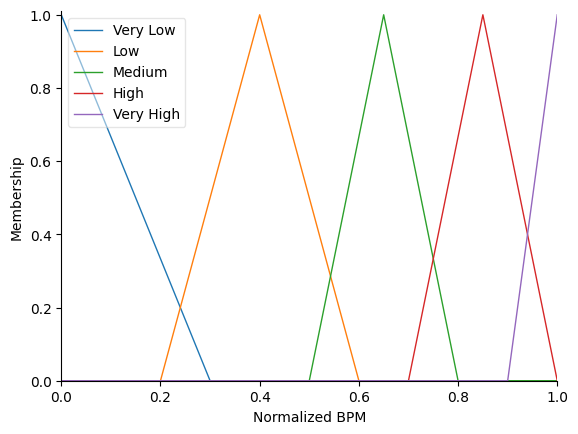

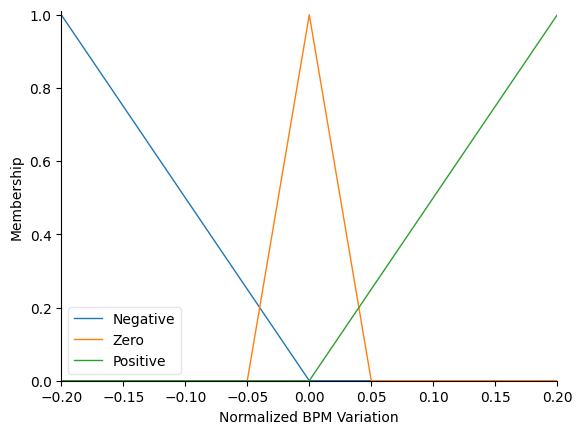

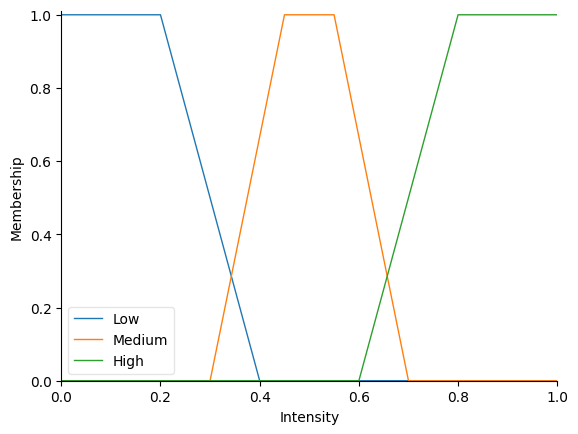

In [9]:
fuzzy_controller = FuzzyController()
fuzzy_controller.view_bpm_antecedent()
fuzzy_controller.view_bpm_variation_antecedent()
fuzzy_controller.view_intensity_consequent()

#### Example

np.float64(0.8999999999999999)

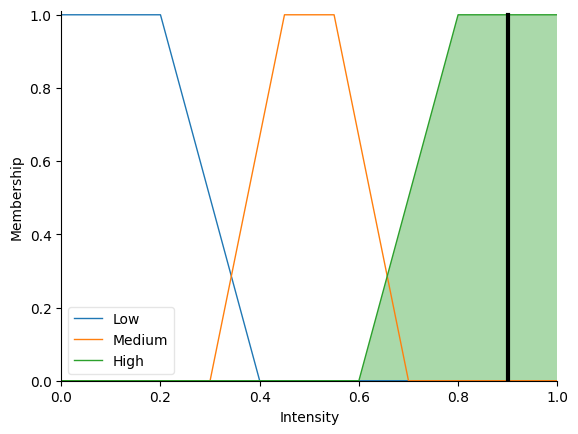

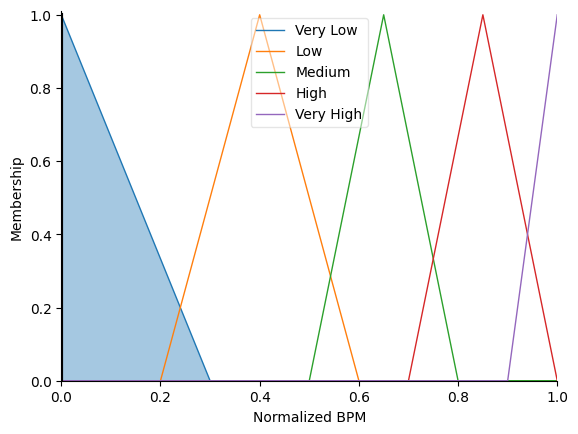

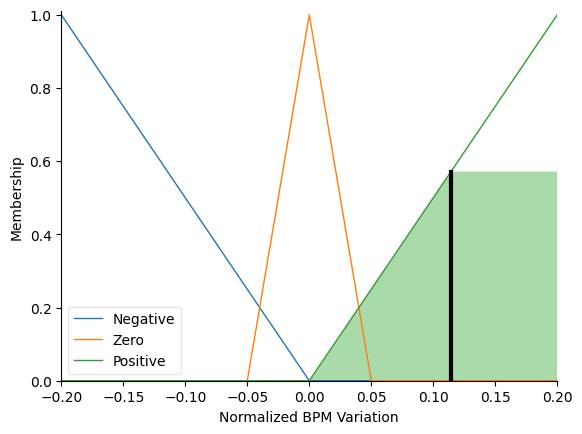

In [10]:
bpm = 20
bpm_variation = 15
fuzzy_controller.calculate_intensity(bpm, bpm_variation, 24, 60, plot_consequent=True, plot_antecedent=True)

In [11]:
bpm = 120
bpm_variation = 10
fuzzy_controller.calculate_intensity(bpm, bpm_variation, plot_consequent=True, plot_antecedent=True)

TypeError: FuzzyController.calculate_intensity() missing 2 required positional arguments: 'age' and 'resting_bpm'

np.float64(0.7545998530595497)

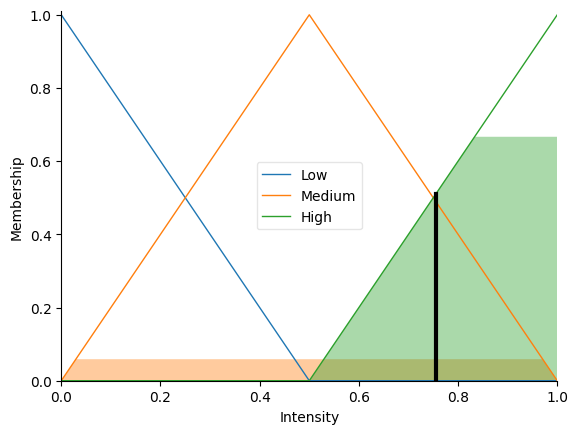

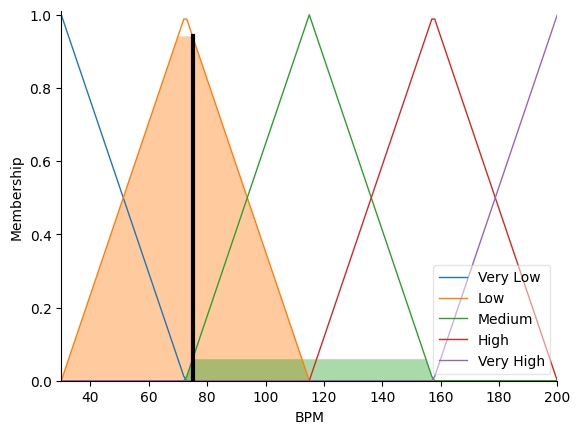

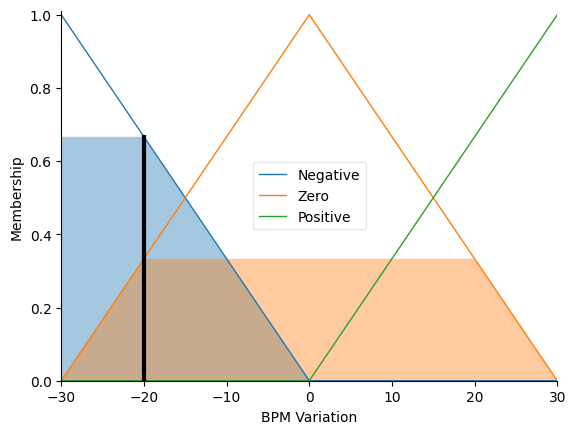

In [ ]:
bpm = 75
bpm_variation = -20
fuzzy_controller.calculate_intensity(bpm, bpm_variation, plot_consequent=True, plot_antecedent=True)

### Energy Calculator Model

In [ ]:
class EnergyCalculator:
    def __init__(self, df_gym_member, df_heart_rates, fuzzy_controller=None):
        self.df_gym_member = df_gym_member
        self.df_heart_rates = df_heart_rates
        self.sesion_minute = 0
        if fuzzy_controller is None:
            self.fuzzy_controller = FuzzyController()
        else:
            self.fuzzy_controller = fuzzy_controller

    def calculate_energy(self, plot_consequent=False, plot_antecedent=False):
        if self.sesion_minute == 0:
            return 0.8 # Default intensity for the first song
        if self.sesion_minute >= len(self.df_heart_rates):
            return -1 # Indicates that the session has ended
        bpm_current = self.df_heart_rates[self.sesion_minute]
        bpm_variation = bpm_current - self.df_heart_rates[self.sesion_minute - 1]
        # print(f"Calculating energy for session minute {self.sesion_minute}")
        # print(f"Previous BPM: {self.df_heart_rates[self.sesion_minute - 1]}, Current BPM: {bpm_current}, BPM Variation: {bpm_variation}")
        return self.fuzzy_controller.calculate_intensity(self.df_heart_rates[self.sesion_minute], bpm_variation, plot_consequent, plot_antecedent)
    
    def pass_song_duration(self, song_duration=2): # Song duration in minutes
        self.sesion_minute += song_duration
        if self.sesion_minute >= len(self.df_heart_rates):
            return -1
        return self.sesion_minute
    
    def get_session_minute(self):
        return self.sesion_minute

    def view_bpm_antecedent(self):
        self.fuzzy_controller.view_bpm_antecedent()
    
    def view_bpm_variation_antecedent(self):
        self.fuzzy_controller.view_bpm_variation_antecedent()
    
    def view_intensity_consequent(self):
        self.fuzzy_controller.view_intensity_consequent()

#### Example

In [ ]:
df_gym.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
1,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
2,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
3,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
4,56,Female,58.0,1.68,168,156,74,1.59,1116.0,HIIT,15.5,2.7,5,3,20.55


In [ ]:
client_used = 2
client_heart_rates = df_heart_rates[df_heart_rates['User_ID'] == client_used]['Heart_Rate'].tolist()

In [ ]:
energy_calculator = EnergyCalculator(df_gym.iloc[client_used], client_heart_rates)

In [ ]:
print(f"Energy level {energy_calculator.calculate_energy(plot_consequent=False, plot_antecedent=False)}")
energy_calculator.pass_song_duration(random.randint(1, 5))

Energy level 0.8


5

In [ ]:
print(f"Energy level {energy_calculator.calculate_energy(plot_consequent=False, plot_antecedent=False)}")
energy_calculator.pass_song_duration(random.randint(1, 5))

Energy level 0.3501343546441047


6

In [ ]:
print(f"Energy level {energy_calculator.calculate_energy(plot_consequent=False, plot_antecedent=False)}")
energy_calculator.pass_song_duration(random.randint(1, 5))

Energy level 0.174024024024024


8

Energy level 0.2690116042405022


c:\Users\Dani\.conda\envs\Master-IA\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


11

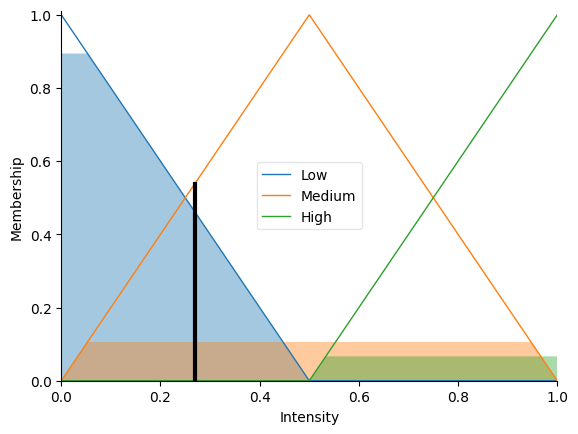

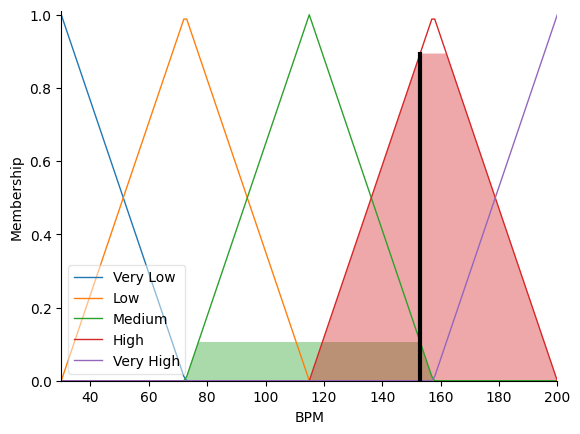

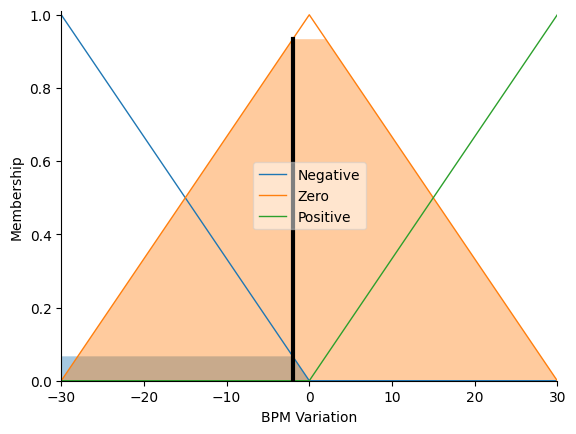

In [ ]:
print(f"Energy level {energy_calculator.calculate_energy(plot_consequent=True, plot_antecedent=True)}")
energy_calculator.pass_song_duration(random.randint(1, 5))